# Content-based Recommendation

## I. Profiling the Tracks

In the first part we try to extract features that represents the content of a certain track. We tried two kind of features: lyrics features and audio features. Finally, the lyrics of a song is reduced to a 4-entry profile and the audio features of a song is reduced to a 9-entry profile.

### 1. Lyrics - Emotion Recognition

#### (1). Baseline Model for Emotion Recognition

We may want to generate a playlist whose songs have similar emotions to the tracks in the seeding playlist. In order to do this, we need to automatically recognize the emotion of a certain track. We chose lyrics as our predictor. The main reason for this choice is that raw data on lyrics are easier to obtain compared to raw acoustic data since recordings of most of the tracks are subject to copyright. After comparing several combinations of input representation and model, we chose feature hashing as the input representation and random forest as the model. This pipeline should act as a baseline model for our future improvement.

The target values used in model training come from last.fm dataset. We used tracks tagged with 'happy' and 'sad' for model selection. These two emotions are less subtle (compared to, say, ‘bittersweet’) and we can assume these two emotions are mutually exclusive. These properties simplify both the classification task and our evaluation of the classification results. We then try to match the tag with lyrics in musiXmatch dataset and LyricWiki.
There are two sources of input for our model. They are preprocessed in different ways. The first source of input is lyrics as BOW from the musiXmatch dataset. The second is raw lyrics from LyricWiki. For lyrics as BOW, we applied the term-frequency-inverse-document-frequency transformation (TF-IDF) to lower the weights of common words in the lyrics, which have lower prediction power. We tried using PCA to reduce the dimensionality, but the resulting improvement in training is limited and does not make up for the drop in model performance. Therefore, no dimensionality reduction is applied. For raw lyrics, we extracted features by feature hashing (as implemented by sklearn’s HashingVectorizer). For both sources of input, we removed the songs that are tagged but has not lyrics (instrumental). 
In the end, we have ~10,000 instances from the first source, and ~5,000 instances from the second source. The number of instances from the second source is significantly lower because we haven’t finished scraping LyricsWiki and our data for raw lyrics is incomplete (And there might be songs that are included in the musiXmatch dataset but not LyricWiki).

We used the following models for classification: support vector machine (SVM), random forest, Gaussian naive Bayes and logistic regression. We used 50% of our instances as the training set and the other half as the validation set. We tried each combination of input representation and model. The model is trained on the training set and evaluated by the validation set. Our pipeline can be summarized as follows.

<img src="images/fig1.png">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import json
from scipy.sparse                    import csr_matrix, vstack
from sklearn.feature_extraction.text import TfidfTransformer, HashingVectorizer
from sklearn.svm                     import SVC
from sklearn.ensemble                import RandomForestClassifier
from sklearn.naive_bayes             import GaussianNB
from sklearn.linear_model            import LogisticRegression

In [2]:
MXM_PATH  = 'databases/mxm_dataset.db'
TAG_PATH  = 'databases/lastfm_tags.db'
META_PATH = 'databases/track_metadata.db'
WIKI_PATH = 'databases/lyricwiki.db'

conn_mxm  = sqlite3.connect(MXM_PATH)
conn_tag  = sqlite3.connect(TAG_PATH)
conn_meta = sqlite3.connect(META_PATH)
conn_wiki = sqlite3.connect(WIKI_PATH)

**BOW + TF-IDF**

In [3]:
"""Get the list of 5000 words used for musiXmatch's BOW representation"""
def get_mxm_vocab(conn_mxm):
    sql  = "SELECT * FROM words"
    res  = conn_mxm.execute(sql)
    data = res.fetchall()
    mxm_vocab = [t[0] for t in data]
    return mxm_vocab

In [4]:
mxm_vocab = get_mxm_vocab(conn_mxm)
mxm_dict  = {mxm_vocab[i] : i for i in range(len(mxm_vocab))}

In [5]:
"""Get the BOW regresentation of the tracks in the form of a sparse matrix"""
def get_bagofwords(tids, mxm_dict, conn_mxm):
    bows = []
    for tid in tids:
        sql  = "SELECT word, count FROM lyrics WHERE track_id='{}'".format(tid)
        res  = conn_mxm.execute(sql)
        data = res.fetchall()
        col  = np.array([mxm_dict[t[0]] for t in data], dtype=np.int16)
        row  = np.zeros(len(col),                       dtype=np.int16)
        cnt  = np.array([t[1] for t in data] )
        bow  = csr_matrix((cnt, (row, col)), shape=(1, 5000))
        bows.append(bow)
    return vstack(bows)

In [6]:
"""Get the track ids. tagged with a certain tag"""
def get_tids_oftag(tag, conn_tag):
    sql  = """SELECT tids.tid FROM tid_tag, tids, tags 
              WHERE tids.ROWID=tid_tag.tid AND tid_tag.tag=tags.ROWID 
              AND tags.tag='{}'""".format(tag)
    res  = conn_tag.execute(sql)
    data = res.fetchall()
    return [t[0] for t in data]

In [7]:
# Get the BOW representation for tracks labelled with 'happy' and 'sad'.
happy_tids = get_tids_oftag('happy', conn_tag)
happy_bows = get_bagofwords(happy_tids, mxm_dict, conn_mxm)
sad_tids   = get_tids_oftag('sad',   conn_tag)
sad_bows   = get_bagofwords(sad_tids, mxm_dict,   conn_mxm)

In [8]:
# Do the term frequency - inverse document frequency transformation.
all_bows = vstack([happy_bows, sad_bows])
tfidf = TfidfTransformer()
all_bows_tfidf = tfidf.fit_transform(all_bows)
all_bows_tfidf.shape

(24716, 5000)

In [9]:
X = all_bows_tfidf.copy().toarray()
y = ['happy']*(happy_bows.shape[0]) + \
    ['sad']*(sad_bows.shape[0])
y = np.array([1 if t == 'happy' else 0 for t in y])

In [10]:
nonzeros = np.sum(X, axis=1) != 0.0
X_nonzero = X[nonzeros]
y_nonzero = y[nonzeros]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_nonzero, y_nonzero, test_size=0.5)

In [12]:
forest = RandomForestClassifier(
    n_estimators=300, max_features=70, max_depth=None, min_samples_split=2)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=70, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [13]:
forest.score(X_train, y_train)

0.984089845577913

In [14]:
forest.score(X_test, y_test)

0.6620399251403618

In [15]:
naive = GaussianNB()
naive.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [16]:
naive.score(X_train, y_train)

0.7622835751052878

In [17]:
naive.score(X_test, y_test)

0.5920149719276356

In [18]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/chenfeiyu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [19]:
logreg.score(X_train, y_train)

0.7719544532834192

In [20]:
logreg.score(X_test, y_test)

0.6781035558328135

In [24]:
# Let's see the top 20 words that indicate happiness
top = np.argsort(logreg.coef_[0])[::-1]
for i in top[:20]: 
    print(mxm_vocab[i])

girl
got
danc
gonna
get
happi
rock
up
about
citi
fine
shine
doo
jump
fun
kiss
hot
sky
check
ya


In [21]:
svc = SVC()
svc.fit(X_train, y_train)

/Users/chenfeiyu/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [22]:
svc.score(X_train, y_train)

0.5484323818437061

In [23]:
svc.score(X_test, y_test)

0.5483468496568933

**raw lyrics + feature hashing**

In [25]:
"""Get the artist and title for tracks with tids"""
def get_artistsandtitles(tids, conn_meta):
    AandTs = []
    for tid in tids:
        sql = "SELECT artist_name, title FROM songs WHERE track_id='{}'".format(tid)
        res = conn_meta.execute(sql)
        AandTs.append(res.fetchall()[0])
    return AandTs

In [26]:
"""Get the raw lyrics of songs with certain artist and title"""
def get_lyrics(AandTs, conn_wiki):
    queryconds = [(t[0].lower().strip(), t[1].lower().strip()) for t in AandTs]
    lyricslist = []
    total_found = 0
    for n, t in enumerate(queryconds):
        res = conn_wiki.execute("""SELECT lyrics FROM songs WHERE artist=? AND title=?""", (t[0], t[1]))
        try:
            lyricslist.append(res.fetchall()[0][0])
            total_found = total_found + 1
        except:
            continue
    return lyricslist

In [27]:
happy_AandTs = get_artistsandtitles(happy_tids, conn_meta)
happy_lyrics = get_lyrics(happy_AandTs, conn_wiki)
sad_AandTs   = get_artistsandtitles(sad_tids,   conn_meta)
sad_lyrics   = get_lyrics(sad_AandTs,   conn_wiki)

In [28]:
def get_nonempty(lyrics):
    nonempty = []
    for l in lyrics:
        if len(l) > 0:
            nonempty.append(l)
    return nonempty

In [29]:
happy_lyrics_nonempty = get_nonempty(happy_lyrics)
sad_lyrics_nonempty   = get_nonempty(sad_lyrics)

In [30]:
vectorizer = HashingVectorizer(n_features=1000)
anotherX   = vectorizer.fit_transform(
    happy_lyrics_nonempty+sad_lyrics_nonempty)

In [31]:
anothery = ['happy']*(len(happy_lyrics_nonempty)) \
    + ['sad']*(len(sad_lyrics_nonempty))

In [32]:
anotherX_train, anotherX_test, anothery_train, anothery_test = train_test_split(
    anotherX, anothery, test_size=0.5)

In [33]:
anotherforest = RandomForestClassifier(
    n_estimators=300, max_features=30, max_depth=None, min_samples_split=2)
anotherforest.fit(anotherX_train, anothery_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=30, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
anotherforest.score(anotherX_train, anothery_train)

0.9799670044779637

In [35]:
anotherforest.score(anotherX_test, anothery_test)

0.7509131613055261

In [36]:
anothernaive = GaussianNB()
anothernaive.fit(anotherX_train.toarray(), anothery_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [37]:
anothernaive.score(anotherX_train.toarray(), anothery_train)

0.6586141880744756

In [38]:
anothernaive.score(anotherX_test.toarray(), anothery_test)

0.615411806291976

In [39]:
anotherlogreg = LogisticRegression()
anotherlogreg.fit(anotherX_train, anothery_train)

/Users/chenfeiyu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [40]:
anotherlogreg.score(anotherX_train, anothery_train)

0.7231911383455103

In [41]:
anotherlogreg.score(anotherX_test, anothery_test)

0.6849298927771886

In [42]:
anothersvc = SVC()
anothersvc.fit(anotherX_train, anothery_train)

/Users/chenfeiyu/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [43]:
anothersvc.score(anotherX_train, anothery_train)

0.5136695734150365

In [44]:
anothersvc.score(anotherX_test, anothery_test)

0.5167903852951573

The accuracy of the models is summarized as below

|                 | SVM | Random Forest | Gaussian Naive Bayes | Logistic Regression |
|-----------------|-----|---------------|----------------------|---------------------|
| BOW + TF-IDF    | 55% | 66%           | 56%                  | 67%                 |
| Feature hashing | 52% | 75%           | 62%                  | 68%                 |

Based on the accuracy scores below, we chose feature hashing + random forest as our baseline model because it has the highest validation accuracy.

#### (2). Comparing LSTM with Baseline Model for Emotion Recognition

Note that in our baseline model the lyrics is essitially represented by the words that appear in it. However, the meaning of text not only depends on the presence of certain words, but also the order of their presence. Therefore we tried using Long Short Term Memory (LSTM) to capture this information. We included a word embedding layer to learn the word2vec representation of the words, and a CNN layer to capture the translational invariance in the lyrics. We compared the performance of this model to our baseline model.

**Training set and Validation set for comparison**

We selected four set of emotions to compare the performance of our baseline model and the new model. The four set of emotions are happy-sad, relax-energetic, cool-oldies, sweet-dark. Again, we selected polarized emotion pairs in purpose, so that we can assume the tracks tagged with one emotion from a pair won't be tagged with another emotion in the same pair. These four pairs of emotions later formed our profile for each track.

In [13]:
import os
import numpy as np
%matplotlib inline
import sqlite3
from sklearn.model_selection import train_test_split
from langdetect              import detect

In [20]:
"""Filter out non-English lyrics"""
def get_english(lyrics):
    english = []
    for l in lyrics:
        try:
            if detect(l) == 'en':
                english.append(l)
        except: continue
    return english

In [21]:
"""Create training set and validation for bi-polar tags."""
def create_train_test(tag1, tag2):
    print('Collecting tids...')
    tag1_tids = get_tids_oftag(tag1, conn_tag)
    tag2_tids = get_tids_oftag(tag2, conn_tag)
    print('Collecting artists and titles...')
    tag1_AandTs = get_artistsandtitles(tag1_tids, conn_meta)
    tag2_AandTs = get_artistsandtitles(tag2_tids, conn_meta)
    print('Collecting lyrics...')
    tag1_lyrics = get_lyrics(tag1_AandTs, conn_wiki)
    tag2_lyrics = get_lyrics(tag2_AandTs, conn_wiki)
    print('{} tracks collected for tag {}, {} tracks collected for tag {}'.format(\
          len(tag1_lyrics), tag1, len(tag2_lyrics), tag2))
    print('Filtering out empty lyrics...')
    tag1_lyrics_nonempty = get_nonempty(tag1_lyrics)
    tag2_lyrics_nonempty = get_nonempty(tag2_lyrics)
    print('Filtering out non-English lyrics...')
    tag1_lyrics_nonempty = get_english(tag1_lyrics_nonempty)
    tag2_lyrics_nonempty = get_english(tag2_lyrics_nonempty)
    print('{} nonempty lyrics for tag {}, {} nonempty lyrics for tag {}'.format(\
          len(tag1_lyrics_nonempty), tag1, len(tag2_lyrics_nonempty), tag2))
    print('Creating predictor set and target set...')
    X = np.array(        tag1_lyrics_nonempty  +         tag2_lyrics_nonempty )
    y = np.array([1]*len(tag1_lyrics_nonempty) + [0]*len(tag2_lyrics_nonempty))
    print('Splitting training set and validation set...')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    print('writing to disk...')
    dirname = tag1+'-'+tag2
    os.mkdir(dirname)
    np.save(dirname + '/X_train.npy', X_train)
    np.save(dirname + '/X_test.npy',  X_test)
    np.save(dirname + '/y_train.npy', y_train)
    np.save(dirname + '/y_test.npy',  y_test)
    print('Finished.')

In [22]:
create_train_test('happy', 'sad')

8508 tracks collected for tag happy, 9078 tracks collected for tag sad
Filtering out empty lyrics...
Filtering out non-English lyrics...
7724 nonempty lyrics for tag happy, 8300 nonempty lyrics for tag sad
Creating predictor set and target set...
Splitting training set and validation set...
writing to disk...
Finished.


In [23]:
create_train_test('relax', 'Energetic')

6287 tracks collected for tag relax, 4521 tracks collected for tag Energetic
Filtering out empty lyrics...
Filtering out non-English lyrics...
5213 nonempty lyrics for tag relax, 4068 nonempty lyrics for tag Energetic
Creating predictor set and target set...
Splitting training set and validation set...
writing to disk...
Finished.


In [25]:
create_train_test('cool', 'oldies')

12457 tracks collected for tag cool, 12769 tracks collected for tag oldies
Filtering out empty lyrics...
Filtering out non-English lyrics...
11064 nonempty lyrics for tag cool, 11970 nonempty lyrics for tag oldies
Creating predictor set and target set...
Splitting training set and validation set...
writing to disk...
Finished.


In [26]:
create_train_test('sweet', 'dark')

5169 tracks collected for tag sweet, 4768 tracks collected for tag dark
Filtering out empty lyrics...
Filtering out non-English lyrics...
4773 nonempty lyrics for tag sweet, 4228 nonempty lyrics for tag dark
Creating predictor set and target set...
Splitting training set and validation set...
writing to disk...
Finished.


**Performance of baseline model (feature hashing + random forest) vs new model (word2vec + LSTM)**

In [ ]:
from keras.models                    import Sequential
from keras.layers                    import Dense, Conv1D, MaxPooling1D, LSTM, Dropout
from keras.layers.embeddings         import Embedding
from keras.preprocessing             import sequence

In [ ]:
def train_forest(tag1, tag2):
    dirname = tag1 + '-' + tag2
    vectorizer = HashingVectorizer(n_features=1000)
    
    print('Preprocessing training set...')
    X_train_forest = vectorizer.fit_transform(np.load(dirname + '/X_train.npy'))
    y_train_forest = np.load(dirname + '/y_train.npy')
    print('Preprocessing validation set...')
    X_test_forest  = vectorizer.transform(np.load(dirname + '/X_test.npy'))
    y_test_forest  = np.load(dirname + '/y_test.npy')
    print('Training random forest...')
    forest = RandomForestClassifier(
    n_estimators=300, max_features=30, max_depth=None, min_samples_split=2)
    forest.fit(X_train_forest, y_train_forest)
    print('Finished.')
    return forest, vectorizer, X_train_forest, y_train_forest, X_test_forest, y_test_forest

In [ ]:
def show_performance(res):
    print('Training accuracy:', res[0].score(res[2], res[3]))
    print('Validation accuracy:', res[0].score(res[4], res[5]))

In [8]:
def lyrics2intarray(lyrics, tokenizer, stemmer):
    lyrics_tokenized = tokenizer.tokenize(lyrics)
    lyrics_stemmed   = [stemmer.stem(w) for w in lyrics_tokenized]
    L = len(lyrics_stemmed)
    intarray = np.zeros(L, dtype=np.int32)
    for i in range(L):
        intarray[i] = mxm_dict.get(lyrics_stemmed[i], 0)
    return intarray

In [9]:
def train_lstm(tag1, tag2):
    stemmer = SnowballStemmer('english')
    tokenizer = RegexpTokenizer(r'\w+')
    dirname = tag1 + '-' + tag2
    print('Preprocessing training set...')
    X_train_lstm = [lyrics2intarray(l, tokenizer, stemmer) for l in np.load(dirname + '/X_train.npy')]
    y_train_lstm = np.load(dirname + '/y_train.npy')
    print('Preprocessing validation set...')
    X_test_lstm  = [lyrics2intarray(l, tokenizer, stemmer) for l in np.load(dirname + '/X_test.npy')]
    y_test_lstm  = np.load(dirname + '/y_test.npy')
    print('Trimming input...')
    max_lyrics_length = 150
    X_train_lstm = sequence.pad_sequences(X_train_lstm, maxlen=max_lyrics_length)
    X_test_lstm  = sequence.pad_sequences(X_test_lstm,  maxlen=max_lyrics_length)
    print('Training LSTM...')
    embedding_vecor_length = 64
    model = Sequential()
    model.add(Embedding(5001, embedding_vecor_length, input_length=max_lyrics_length))
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(LSTM(50))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    model.fit(X_train_lstm, y_train_lstm, validation_data=(X_test_lstm, y_test_lstm), epochs=5, batch_size=64)
    return model, X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm

In [10]:
show_performance(train_forest('happy', 'sad'))

Preprocessing training set...
Preprocessing validation set...
Training random forest...
Finished.
Training accuracy: 0.9726187690147438
Validation accuracy: 0.7759750390015601


In [11]:
train_lstm('happy', 'sad')

Preprocessing training set...
Preprocessing validation set...
Trimming input...
Training LSTM...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 64)           320064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 150, 64)           12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 75, 64)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 75, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                23000     
_____________________________________________

(<keras.engine.sequential.Sequential at 0x1103d89b0>,
 array([[   0,    0,    0, ...,   25,   14, 1112],
        [ 141,    2, 1318, ...,   59,    2,  513],
        [  92,    3,   16, ...,  107,   10, 2921],
        ...,
        [ 134,   35,  169, ...,    3,    4,   29],
        [   0,    0,    0, ...,   13,   27,    7],
        [1001,  245,  503, ...,  119,   13,  154]], dtype=int32),
 array([0, 0, 1, ..., 1, 1, 0]),
 array([[   0,    2,    0, ...,    7,   37,  941],
        [ 880,    3,    3, ...,  545, 1748, 1543],
        [  14,  542,   46, ...,   15,    3,   16],
        ...,
        [   0,    0,    0, ..., 1803,   11,  569],
        [  12,    9,    2, ...,  416,  264,  200],
        [  61,   36,   30, ...,  171, 1222,  125]], dtype=int32),
 array([0, 0, 0, ..., 1, 0, 1]))

In [12]:
show_performance(train_forest('relax', 'Energetic'))

Preprocessing training set...
Preprocessing validation set...
Training random forest...
Finished.
Training accuracy: 0.9888200431034483
Validation accuracy: 0.7926763597199784


In [13]:
train_lstm('relax', 'Energetic')

Preprocessing training set...
Preprocessing validation set...
Trimming input...
Training LSTM...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 64)           320064    
_________________________________________________________________
dropout_4 (Dropout)          (None, 150, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 150, 64)           12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 75, 64)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 75, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                23000     
_____________________________________________

(<keras.engine.sequential.Sequential at 0x1a319659e8>,
 array([[  83,    1,   61, ...,  135,    3,   37],
        [  28, 3422,    2, ...,  976,  523,  172],
        [   0,    0,    0, ...,  254,   59,  390],
        ...,
        [ 267,    4,  251, ...,  336,    6,   92],
        [  53,  476,   28, ...,   65,  175,  175],
        [1298,    2, 1950, ...,  312,   46,   46]], dtype=int32),
 array([0, 1, 0, ..., 1, 0, 0]),
 array([[   0,    0,    0, ...,  147,  131,    3],
        [  48,  103,  476, ...,  885,    0,  106],
        [ 687, 1109,   13, ...,   15,    3,   84],
        ...,
        [4717,  103,  476, ...,  539,   13, 1685],
        [ 399,    1, 1362, ...,   30,   12,  399],
        [   0,  135,    0, ...,    0,  336, 1672]], dtype=int32),
 array([1, 0, 1, ..., 1, 0, 0]))

In [16]:
show_performance(train_forest('cool', 'oldies'))

Preprocessing training set...
Preprocessing validation set...
Training random forest...
Finished.
Training accuracy: 0.9468171704563955
Validation accuracy: 0.7803342739309747


In [17]:
train_lstm('cool', 'oldies')

Preprocessing training set...
Preprocessing validation set...
Trimming input...
Training LSTM...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 150, 64)           320064    
_________________________________________________________________
dropout_10 (Dropout)         (None, 150, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 150, 64)           12352     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 75, 64)            0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 75, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                23000     
_____________________________________________

(<keras.engine.sequential.Sequential at 0x1a3a6c96a0>,
 array([[ 228,  312,   73, ...,  577,   66,  399],
        [  76,  976,  523, ...,  545,   37,  588],
        [ 427,  373,    7, ...,  525,    4,    7],
        ...,
        [1234,   89,    2, ...,    1,   54,  487],
        [   8,  615,    8, ...,    8,  615,    8],
        [ 326,    2,   85, ...,  686,    4,  125]], dtype=int32),
 array([0, 0, 1, ..., 0, 1, 1]),
 array([[  48, 1120,  211, ...,   94,    4,   66],
        [  46,   46,   46, ...,  989,   80,  434],
        [  88,   72,   22, ...,  105,    0,    0],
        ...,
        [1110,  390,    7, ...,  616,  180,    3],
        [   7,  156,    7, ...,  335,    4,   44],
        [   0,    0,    0, ...,   76,    2,  358]], dtype=int32),
 array([1, 0, 1, ..., 1, 0, 0]))

In [18]:
show_performance(train_forest('sweet', 'dark'))

Preprocessing training set...
Preprocessing validation set...
Training random forest...
Finished.
Training accuracy: 0.9870833333333333
Validation accuracy: 0.7679067184897279


In [19]:
train_lstm('sweet', 'dark')

Preprocessing training set...
Preprocessing validation set...
Trimming input...
Training LSTM...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 150, 64)           320064    
_________________________________________________________________
dropout_13 (Dropout)         (None, 150, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 150, 64)           12352     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 75, 64)            0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 75, 64)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                23000     
_____________________________________________

(<keras.engine.sequential.Sequential at 0x1a33858b70>,
 array([[ 154,   57,    6, ...,    6,  257,   37],
        [  67,    2, 3514, ...,   59,   14, 1255],
        [  17,    2,  563, ...,   50,  283,   50],
        ...,
        [   0,    0,    0, ...,    6,  279,    0],
        [  25, 3795,   49, ...,   41,   11,   73],
        [ 798,  106,    6, ...,   66,  747,  798]], dtype=int32),
 array([0, 1, 0, ..., 0, 1, 0]),
 array([[  61,   11, 3252, ...,  200,   92, 2211],
        [   3,  110,  392, ...,  392,  110,  392],
        [  74,  762,    1, ...,    4,  131,    1],
        ...,
        [   1,   57, 2539, ...,    0,    0,    0],
        [ 290,    6,  138, ...,   92,    1, 3856],
        [ 476,   22,  257, ..., 1110,   22,  251]], dtype=int32),
 array([0, 0, 1, ..., 1, 0, 0]))

The accuracy of the models is summarized as below

|                 | happy-sad | relax-energetic | cool-oldies | sweet-dark |
|-----------------|-----|---------------|----------------------|---------------------|
| baseline model    | 78% | 79%           | 78%                  | 77%                 |
| word2vec + LSTM | 74% | 75%           | 76%                  | 73%                 |

Althought the performace of the two models are comparable in all four pair of emotions, we found that our baseline model outperformed this new model in all cases. It is possible that with better tuning the accuracy of wrod2vec + LSTM can can be higher, but considering our limited time, we chose our baseline model as our final model for lyrics-based emotion recognition.

#### (3). Final Model for Emotion Recognition

We built four pipelines for four dimensions of emotion: happy-sad, relax-energetic, cool-oldies, sweet-dark. This time, the model is trained on all our available data for best performance.

In [ ]:
def train_forest(X, y):
    vectorizer = HashingVectorizer(n_features=1000)
  
    print('Preprocessing training set...')
    X_train_forest = vectorizer.fit_transform(X)
    y_train_forest = y
    print('Training random forest...')
    forest = RandomForestClassifier(
        n_estimators=300, max_features=30, max_depth=None, min_samples_split=2)
    forest.fit(X_train_forest, y_train_forest)
    print('Finished.')
    return forest, vectorizer

In [6]:
def save_forest_pipeline(res, tag1, tag2):
    pipeline = Pipeline([('vectorizer', res[1]), ('forest', res[0])])
    dump(pipeline, tag1+'-'+tag2+'pipeline.joblib')

In [8]:
def load_forest_pipeline(tag1, tag2):
    return load(tag1+'-'+tag2+'pipeline.joblib')

In [7]:
def create_pipeline(tag1, tag2):
    X, y = create_train(tag1, tag2)
    res = train_forest(X, y)
    save_forest_pipeline(res, tag1, tag2)

In [9]:
create_pipeline('happy', 'sad')

8508 tracks collected for tag happy, 9078 tracks collected for tag sad
Filtering out empty lyrics...
Filtering out non-English lyrics...
7721 nonempty lyrics for tag happy, 8302 nonempty lyrics for tag sad
Creating predictor set and target set...
Preprocessing training set...
Training random forest...
Finished.


In [10]:
create_pipeline('relax', 'Energetic')

6287 tracks collected for tag relax, 4521 tracks collected for tag Energetic
Filtering out empty lyrics...
Filtering out non-English lyrics...
5214 nonempty lyrics for tag relax, 4072 nonempty lyrics for tag Energetic
Creating predictor set and target set...
Preprocessing training set...
Training random forest...
Finished.


In [11]:
create_pipeline('cool', 'oldies')

12457 tracks collected for tag cool, 12769 tracks collected for tag oldies
Filtering out empty lyrics...
Filtering out non-English lyrics...
11062 nonempty lyrics for tag cool, 11969 nonempty lyrics for tag oldies
Creating predictor set and target set...
Preprocessing training set...
Training random forest...
Finished.


In [12]:
create_pipeline('sweet', 'dark')

5169 tracks collected for tag sweet, 4768 tracks collected for tag dark
Filtering out empty lyrics...
Filtering out non-English lyrics...
4774 nonempty lyrics for tag sweet, 4225 nonempty lyrics for tag dark
Creating predictor set and target set...
Preprocessing training set...
Training random forest...
Finished.


#### (4). Profiling the Emotion of Tracks

We profiled the tracks in the Million Playlist Dataset using the four piplines.

In [ ]:
TRACKURI_PATH = 'databases/track_uri.db'
PROFILES_PATH = 'databases/profiles.db'

conn_trackuri = sqlite3.connect(TRACKURI_PATH)
conn_profiles = sqlite3.connect(PROFILES_PATH)

In [ ]:
conn_profiles.execute("""CREATE TABLE profiles (
                         track_uri TEXT,
                         happy_sad REAL,
                         relax_energetic REAL,
                         cool_oldies REAL,
                         sweet_dark REAL)""")
conn_profiles.execute("""CREATE INDEX profile_track_uris ON profiles (track_uri)""")
conn_profiles.commit()

In [5]:
"""
Profile the emotion of a song:
[
1: happy, -1:sad;
1: relax, -1:energetic;
1: cool,  -1:oldies;
1: sweet, -1:dark;
]
"""
def make_profile(lyrics, pipelinelist):
    profiles = np.zeros(shape=(len(lyrics), len(pipelinelist)))
    for i, pipeline in enumerate(pipelinelist):
        profiles[:, i] = (pipeline.predict_proba(lyrics)[:, 1] - 0.5) * 2.0
    return profiles

In [ ]:
def build_profiles(urilist, conn_trackuri, conn_wiki, 
                   conn_profiles):
    AandTs = get_artistsandtitles_byuri(urilist, conn_trackuri)
    lyrics = get_lyrics(AandTs, conn_wiki)
    urilist_, lyrics_ = get_nonempty(urilist, lyrics)
    urilist_, lyrics_ = get_english(urilist_, lyrics_)
    assert len(urilist_) == len(set(urilist_))
    profiles = make_profile(lyrics_, 
                            [pipeline1, pipeline2, pipeline3, pipeline4])
    insertvals = [(uri, profile[0], profile[1], profile[2], profile[3]) 
                  for uri, profile in zip(urilist_, profiles)]
    conn_profiles.executemany("""INSERT INTO profiles (track_uri, happy_sad, relax_energetic, cool_oldies, sweet_dark)
                             VALUES (?, ?, ?, ?, ?)""", insertvals)
    conn_profiles.commit()

In [1]:
batch_size = 1000
batch_numb = len(all_uris) // batch_size
for i in range(batch_numb+1):
    batch = all_uris[batch_size*i: batch_size*(i+1)]
    build_profiles(batch, conn_trackuri, conn_wiki, conn_profiles)

### 2. Audio Feature - Genre Recognition

We

#### (1) Preprocessing Data

In [3]:
genre_of_interest = ['rock','pop','alternative','indie','electronic',
                    'jazz','metal','soul','folk','instrumental',
                     'punk','blues','Hip-Hop']
feature_of_interest = ['danceability','energy','key','loudness','mode','tempo']

In [ ]:
## connect to sql database
TAG_PATH  = 'lastfm_tags.db'
conn_tag  = sqlite3.connect(TAG_PATH)

In [5]:
## data query
sql  = """SELECT tids.tid, tags.tag, tid_tag.val FROM tid_tag, tids, tags 
          WHERE tids.ROWID=tid_tag.tid AND tid_tag.tag=tags.ROWID 
          AND tags.tag in ('rock','pop','alternative','indie','electronic',
          'jazz','metal','soul','folk','instrumental','punk','blues','Hip-Hop')
          ORDER BY tids.tid"""
tag_data = np.array(conn_tag.execute(sql).fetchall())


In [6]:
## construct empty dictionary
data_dict = {track_id:{} for track_id in tag_data[:,0]}
for track_id, item in itertools.product(tag_data[:,0], feature_of_interest+genre_of_interest):
    data_dict[track_id][item] = 0

In [7]:
## fill dictionary with tag values
for entry in tag_data:
    data_dict[entry[0]][entry[1]]=float(entry[2])

In [8]:
## get file paths for songs of interest
song_data_path = os.path.join(os.getcwd(),'millionsong','data')
sub = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N',
        'O','P','Q','R','S','T','U','V','W','X','Y','Z']

song_fn = {}
for sub1, sub2, sub3 in itertools.product(sub,sub,sub):
    song_path = os.path.join(song_data_path,sub1,sub2,sub3)
    try:
        for fn in os.listdir(song_path):
            if fn.split('.')[0] in data_dict:
                song_fn[fn.split('.')[0]] = os.path.join(song_path, fn)
    except FileNotFoundError: pass

In [ ]:
## read audio feature data into the dictionary
for fn in song_fn:
    s = h5py.File(song_fn[fn], 'r')
    analysis = np.array(s.get('analysis').get('songs'))[0]
    for feature in feature_of_interest:
        data_dict[fn][feature] = analysis[feature]


In [ ]:
## turn dictionary into dataframe and drop unfound rows
data_df = pd.DataFrame.from_dict(data_dict,orient='index')
set1 = set(data_dict.keys())
set2 = set(song_fn.keys())
drop_index = list(set1 - set2)
data_df = data_df.drop(drop_index, axis=0)
data_df = data_df.drop(['danceability','energy'], axis=1)

In [ ]:
## save data to csv
data_df.to_csv('audio_tag.csv')

In [10]:
data_df = pd.read_csv('audio_tag.csv',index_col = 0)
key_dummies = pd.get_dummies(data_df['key'])
for key in key_dummies:
    data_df.insert(key,'key_'+str(key),key_dummies[[key]])
data_df = data_df.drop(columns=['key','key_0'])

In [11]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_df, test_size = 0.2,random_state=42)

In [12]:
X_train = train_data.iloc[:,0:14]
X_test = test_data.iloc[:,0:14]

#### (2) Baseline Model with Logistic Regression

In [17]:
genre_logit_scores = {}
genre_logit_models = {}

for genre in genre_of_interest:
    y_train = train_data[genre].values
    y_test = test_data[genre].values
    tag_train = np.where(y_train > 0,1,0)
    tag_test = np.where(y_test > 0,1,0)
    Logit = LogisticRegression(solver='liblinear')
    Logit.fit(X_train,tag_train)
    score = Logit.score(X_test,tag_test)
    genre_logit_models[genre] = Logit
    genre_logit_scores[genre] = score

In [18]:
genre_logit_scores

{'rock': 0.6387224779920251,
 'pop': 0.7582108527729086,
 'alternative': 0.8030743744341494,
 'indie': 0.8300425712249341,
 'electronic': 0.8361682044959836,
 'jazz': 0.8940149866122166,
 'metal': 0.9025677575944369,
 'soul': 0.9163600639531524,
 'folk': 0.915608807042552,
 'instrumental': 0.9237763180706181,
 'punk': 0.9243542080018492,
 'blues': 0.9262227187794965,
 'Hip-Hop': 0.9427503708127059}

The accuracies are quite high for most of the genres. However, after investigation, we found that it is only because the model is very unbalanced. Comparing the number of all songs, each genre includes very few songs. For example, the classification model for folk songs classifies all songs to be not folk songs, and the accuracy is still higher than 90%.

#### (3) Improved Logistic Regression

Next, we try to balance the model. For each genre classification model, we keep all observations that classify the song as of that genre, and sample twice as many observations that classify the song as not belonging to that genre.

In [19]:
genre_logit_scores2 = {}
genre_logit_models2 = {}

for genre in genre_of_interest:
    train_pos = train_data.loc[train_data[genre]>0]
    train_neg = train_data.loc[train_data[genre]==0]
    train_neg_selected = train_neg.sample(n=min(len(train_neg),2*len(train_pos)),replace=False,random_state=42)
    train_full = pd.concat([train_pos,train_neg_selected])

    x_train = train_full.iloc[:,0:14]
    y_train = train_full[genre].values
    y_test = test_data[genre].values
    tag_train = np.where(y_train > 0,1,0)
    tag_test = np.where(y_test > 0,1,0)
    Logit = LogisticRegression(solver='liblinear')
    Logit.fit(x_train,tag_train)
    score = Logit.score(X_test,tag_test)
    genre_logit_models2[genre] = Logit
    genre_logit_scores2[genre] = score

In [20]:
genre_logit_scores2

{'rock': 0.6387224779920251,
 'pop': 0.7581338007820777,
 'alternative': 0.8027854294685339,
 'indie': 0.8299269932386878,
 'electronic': 0.8243021979080385,
 'jazz': 0.8429680426868029,
 'metal': 0.8319881339934121,
 'soul': 0.9115635775239342,
 'folk': 0.8547955232793327,
 'instrumental': 0.8680099397068172,
 'punk': 0.8531196424787626,
 'blues': 0.865948798952093,
 'Hip-Hop': 0.8713039123148344}

The resulting model is no longer classifying most of the songs as not belonging to any genre. However, the accuracy is much lower.

#### (4). Random Forest

Furthermore, we try to classify song genre through a Random Forest model.

In [22]:
## select hyperparameter n_estimators
mean_scores = []
ns = np.arange(10,51,5)

for n in ns:
    scores = []
    for genre in genre_of_interest:
        y_train = train_data[genre].values
        y_test = test_data[genre].values
        tag_train = np.where(y_train > 0,1,0)
        tag_test = np.where(y_test > 0,1,0)
        randomforest = RandomForestClassifier(n_estimators=n, max_depth=None)
        randomforest.fit(X_train,tag_train)
        scores.append(randomforest.score(X_test,tag_test))
    mean_scores.append(np.mean(scores))

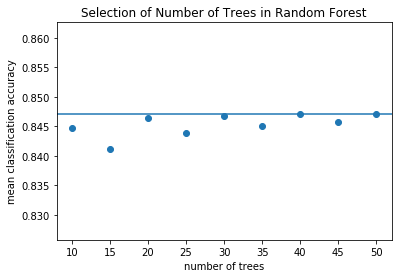

In [23]:
plt.scatter(ns,mean_scores)
plt.axhline(mean_scores[-3])
plt.title('Selection of Number of Trees in Random Forest')
plt.xlabel('number of trees')
plt.ylabel('mean classification accuracy');

When the number of trees is 40, the mean classification accuracy is the highest, and it requires less computation power than having 50 trees.

In [24]:
genre_rf_scores = {}
genre_rf_models = {}

for genre in genre_of_interest:
    y_train = train_data[genre].values
    y_test = test_data[genre].values
    tag_train = np.where(y_train > 0,1,0)
    tag_test = np.where(y_test > 0,1,0)
    
    randomforest = RandomForestClassifier(n_estimators=40, max_depth=None)
    randomforest.fit(X_train,tag_train)
    score = randomforest.score(X_test,tag_test)
    genre_rf_models[genre] = randomforest
    genre_rf_scores[genre] = score

In [25]:
genre_rf_scores

{'rock': 0.6075549477009612,
 'pop': 0.7153892088686842,
 'alternative': 0.7731396759963786,
 'indie': 0.8058482461040587,
 'electronic': 0.8222603201510219,
 'jazz': 0.884961377689596,
 'metal': 0.8916841638895845,
 'soul': 0.908924546837979,
 'folk': 0.9087319168609019,
 'instrumental': 0.9185560456918306,
 'punk': 0.9168223758981373,
 'blues': 0.9197696145474159,
 'Hip-Hop': 0.9382813553445187}

Random Forest model is less affected by the unbalanced problem, and it produces higher accuracies than the balanced Logistic Regression models. Thus, we choose to use Random Forest to classify genres.

#### (5). Profiling the Genres of Tracks

In [26]:
MPD_audio = pd.read_csv('MPD_audio.csv')

key_dummies_MPD = pd.get_dummies(MPD_audio['key'])
for key in key_dummies_MPD:
    MPD_audio.insert(key+1,'key_'+str(key),key_dummies_MPD[[key]])
MPD_audio = MPD_audio.drop(columns=['key','key_0'])

In [27]:
for genre in genre_of_interest:
    proba = genre_rf_models[genre].predict_proba(MPD_audio.iloc[:,1:15])
    MPD_audio[genre] = proba[:,1]

MPD_audio.to_csv('MPD_genre_2.csv',index=False)

In [ ]:
GENREPROFILES_PATH = 'databases/genre_profiles.db'
conn_genreprofiles = sqlite3.connect(GENREPROFILES_PATH)

genre_df = pd.read_csv('MPD_genre.csv')
genre_df.to_sql('profiles', con=conn_genreprofiles, index=False)
conn_genreprofiles.execute("""CREATE INDEX profile_track_uris ON profiles (track_uri)""")

### 3. Full Audio Feature

We have used only part of the audio features data from the Spotify API to classify the genres of the songs. The full audio feature data are too inserted into a relational database for latter use.

#### (1). Profiling the Audio Features of Tracks

In [ ]:
AUDIOPROFILES_PATH = 'databases/audio_profiles.db'
conn_audioprofiles = sqlite3.connect(AUDIOPROFILES_PATH)

audio_df = pd.read_csv('MPD_audio_full.csv')
audio_df.to_sql('profiles', con=conn_audioprofiles, index=False)
# build index to accelerate querying
conn_audioprofiles.execute("""CREATE INDEX profile_track_uris ON profiles (track_uri)""")

## II. Recommendation Based on Profiles

The recommendations were generated by finding tracks that has most similar profiles as the input (seeding) tracks. The similarity is defined by cosine similarity and the we achived efficient retrieval of similarity neighbors by putting all our tracks into a KD-tree (It can be proved that when the profiles are normalized, the tracks that have smallest euclidean distances are the tracks that have the highest cosine similarity). To address the problem that the tracks in an input playlist may not be homogeneous, we first perform a clustering on the input tracks and then give recommendations based on each clustering center. For each generated playlist is generated, we linearly score the tracks, i.e. the i-th closest track to the seed has a score of 1 - i/(# tracks generated per playlist).

In [121]:
"""functions to query database for titles and profiles"""
def get_titles(seed_urilist):
    titles   = [get_title_byuri(uri) for uri in seed_urilist]
    return [t for t in titles if t is not None]
def get_profiles(seed_urilist, conn_profiles):
    profiles = [get_profile_byuri(uri, conn_profiles) for uri in seed_urilist]
    return np.array([p for p in profiles if p is not None])
def get_title_byuri(uri):
    sql  = "SELECT track_name FROM track_uri WHERE track_uri='{}'".format(uri)
    res  = conn_trackuri.execute(sql)
    try:
        return res.fetchall()[0][0]
    except:
        return None
def get_profile_byuri(uri, conn_profiles):
    sql  = "SELECT * FROM profiles WHERE track_uri='{}'".format(uri)
    res  = conn_profiles.execute(sql)
    try:
        return res.fetchall()[0][1:]
    except:
        return None
def get_all_profiles(conn_profiles, dropnull=False):
    sql  = """SELECT * from profiles"""
    res  = conn_profiles.execute(sql)
    data = res.fetchall()
    if dropnull:
        for p in data:
            if None in p: data.remove(p)
    return data

In [122]:
"""set up kdtree for a certain kind of profiles"""
def build_kdtree(conn_profiles):
    print('Reading profiles from sqlite...')
    all_profiles = get_all_profiles(conn_profiles, dropnull=True)
    print('Creating dictionary got URI ...')
    dict_ind2uri = {i: t[0] for i, t in enumerate(all_profiles)}
    dict_uri2ind = {v: k    for k, v in dict_ind2uri.items()   }
    print('Building KD-tree...')
    profile_values = np.array([t[1:] for t in all_profiles])
    # profiles are normalized so that their euclidian neighbors are also their cosine-similarity neighbors
    profile_values = normalize(profile_values) 
    kdtree = KDTree(profile_values, leaf_size=2)
    return kdtree, dict_ind2uri, dict_uri2ind

In [123]:
"""make recommendation based on single seed profile"""
def get_recm_byprofile(seed_profile, kdtree, dict_ind2uri, exclude_titles, num_recm):
    search_ratio = 2
    while True:
        _,    ind = kdtree.query([seed_profile], k=num_recm*search_ratio)
        recm_list = []
        for recm_ind in ind[0]:
            recm_uri   = dict_ind2uri[recm_ind]
            recm_title = get_title_byuri(recm_uri)
            if recm_title in exclude_titles: continue
            recm_list.append(recm_uri)
            if len(recm_list) == num_recm:   return recm_list
        if len(recm_list) < num_recm: search_ratio *= 2
    return recm_list
"""make recommendation based on multiple seed profiles"""
def create_recommendations(seed_profiles, kdtree, dict_ind2uri, exclude_titles, num_recm=500, num_cntr=None):
    if len(seed_profiles) == 0: return []
    num_seed = len(seed_profiles)
    if num_cntr is None: num_cntr = int(np.sqrt(num_seed))
    kmeans = KMeans(n_clusters=num_cntr).fit(seed_profiles)
    num_recm_per_cntr = int(num_recm/num_cntr)+1
    lists = []
    for c in kmeans.cluster_centers_:
        lists.append( get_recm_byprofile(c, kdtree, dict_ind2uri, exclude_titles, num_recm_per_cntr) )
    recm_list = [None] * num_cntr * num_recm_per_cntr
    for i in range(num_cntr):
        recm_list[i::num_cntr] = lists[i]
    return recm_list[:num_recm]

In [124]:
def generate_val_Y(val_X, conn_profiles, kdtree, dict_ind2uri, num_recm_per_list, verbose=True):
    val_Y = []
    total = len(val_X); every = total // 100
    for i, seedlist in enumerate(val_X):
        titles   = get_titles(seedlist)
        profiles = get_profiles(seedlist, conn_profiles)
        val_Y.append( create_recommendations(profiles, kdtree, dict_ind2uri, 
                                             exclude_titles=titles, num_recm=num_recm_per_list) )
        if verbose and i%every == 0: print('{0:3d} / 100 finished'.format(i//every))
    return val_Y

In [51]:
genrekdtree, genredict_ind2uri, genredict_uri2ind = build_kdtree(conn_genreprofiles)

Reading profiles from sqlite...
Creating dictionary got URI ...
Building KD-tree...


In [ ]:
genreval_Y = generate_val_Y(val_X, conn_genreprofiles, genrekdtree, genredict_ind2uri, 500, verbose=True)
with open('val_Y_genre.json', 'w') as f:
    json.dump(genreval_Y, f)

In [63]:
audiokdtree, audiodict_ind2uri, audiodict_uri2ind = build_kdtree(conn_audioprofiles)

Reading profiles from sqlite...
Creating dictionary got URI ...
Building KD-tree...


In [ ]:
audioval_Y = generate_val_Y(val_X, conn_audioprofiles, audiokdtree, audiodict_ind2uri, 500, verbose=True)
with open('val_Y_audio.json', 'w') as f:
    json.dump(audioval_Y, f)

In [66]:
lyrickdtree, lyricdict_ind2uri, lyricdict_uri2ind = build_kdtree(conn_lyricprofiles)

Reading profiles from sqlite...
Creating dictionary got URI ...
Building KD-tree...


In [ ]:
lyricval_Y = generate_val_Y(val_X, conn_lyricprofiles, lyrickdtree, lyricdict_ind2uri, 500, verbose=True)
with open('val_Y_lyric.json', 'w') as f:
    json.dump(lyricval_Y, f)

In [ ]:
def scoring(val_Y, method='linear'):
    scores = []
    length = len(val_Y[0])
    if method == 'linear':
        for l in val_Y:
            score_dict = {}
            for i, t in enumerate(l):
                score_dict[t] = 1-i/length
            scores.append(score_dict)
    elif method == 'exp':
        for l in val_Y:
            score_dict = {}
            for i, t in enumerate(l):
                score_dict[t] = np.exp(-4*i/length)
            scores.append(score_dict)
    else: raise ValueError('method not found')
    return scores

In [ ]:
genreval_Y_score = scoring(genreval_Y)
audioval_Y_score = scoring(audioval_Y)
lyricval_Y_score = scoring(lyricval_Y)